Морфологический анализ <br/>
Домашнее задание 6 <br/>
**Голев Александр 135М**

# Реализовать следующий метод выделения отличий изображений f и g по форме.


In [3]:
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import random

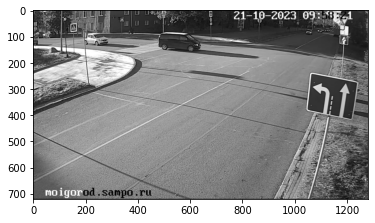

In [4]:
# Загружаем изображение
f_gray = cv2.cvtColor(cv2.imread('g_2.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(f_gray, cv2.COLOR_BGR2RGB))

### 2. Аппроксимация формы фрагмента изображения f формой мозаичного изображения.


Аппроксимация формы изображения формой мозаичного изображения делается путем решения следующей задачи.

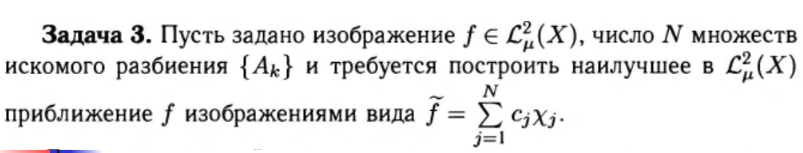

Ее решение имеет следующий вид

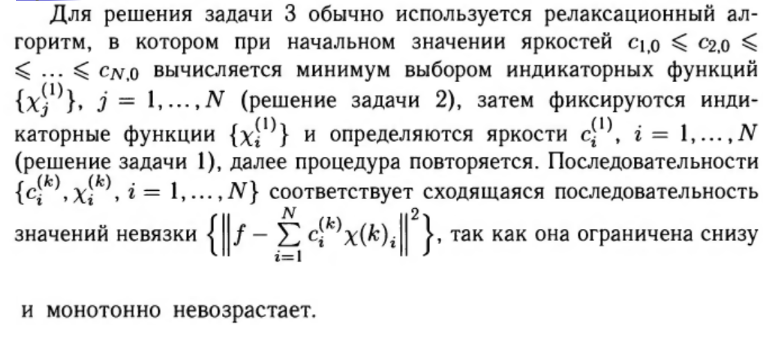



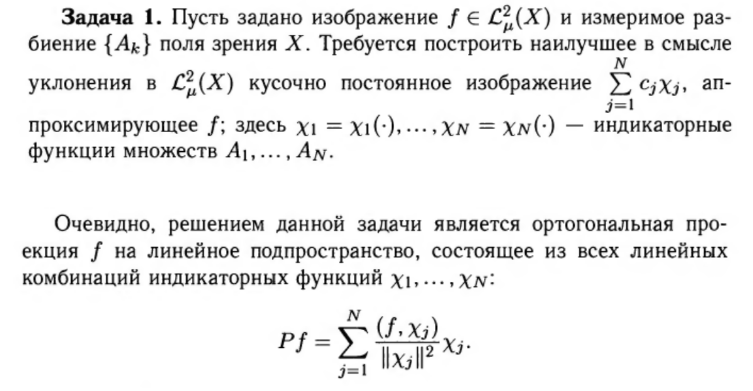

Таким образом, сначала нужно определить уровни квантования исходного изображения.

Определим уровни квантования изображения (значений яркостей), можем воспользоваться методом анализа гистограммы изображения (корректный вариант).

In [5]:
def get_levels(img, threshold = 16,show=False):
    quantization_levels = []  # Изначально уровней нет
    
    hist = cv2.calcHist(img, [0], None, [256], [0, 256])

    # Проанализируем гистограмму, чтобы найти количество уровней квантования
    # Здесь мы берем только те уровни, чье количество пикселей больше определенного порога
    for i in range(256):
        if hist[i] > threshold:
            quantization_levels.append(i)
    
    if show:
        print(f'Уровни квантования: {len(quantization_levels)}')
        plt.plot(hist)
        plt.title('Гистограмма изображения')
        plt.xlabel('Значения яркости')
        plt.ylabel('Количество пикселей')
        plt.show()
    #print(np.linspace(0,255,10,dtype=np.int16))
    return quantization_levels

In [6]:
levels= get_levels(f_gray,threshold = 16,show=True)

Уровни квантования: 25


In [7]:
levels

[30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 60,
 61,
 235]

Построим разбиение поля зрения наиболее приближенное к исходному изображению. 

In [8]:
def find_level(pixel):
    min_diff = 256
    min_index = -1
    for i, level in enumerate(levels):
        diff = abs(pixel - level)
        if (diff < min_diff):
            min_diff = diff
            min_index = level
    return min_index

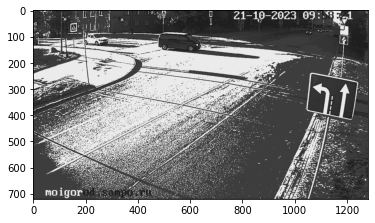

In [9]:
#сначала округлим цвета до "палитры"
exaple_colorized = np.vectorize(find_level)(f_gray).astype(np.uint8)
plt.imshow(cv2.cvtColor(exaple_colorized, cv2.COLOR_BGR2RGB))

Определим индикаторные функции (маски 1, 0 для определенного уровня яркости)

In [10]:
def get_masks(img, src_levels):
    colorized = np.vectorize(find_level)(img).astype(np.uint8)
    masks = []
    for level in src_levels:
        c = img.copy()*0
        c[colorized==level] = 1
        c[colorized!=level] = 0
        masks.append(c)
    return masks

In [11]:
masks = get_masks(f_gray, levels)

In [12]:
# вспомогательная функция для отрисовки
def showOneLine(images, texts, dim = 3):
    plt.figure(figsize=(28, 16))
    length = len(images)
    for i, (image, text) in enumerate(zip(images, texts)):
        plt.subplot(length//dim+1, dim, i+1)
        plt.title(text)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

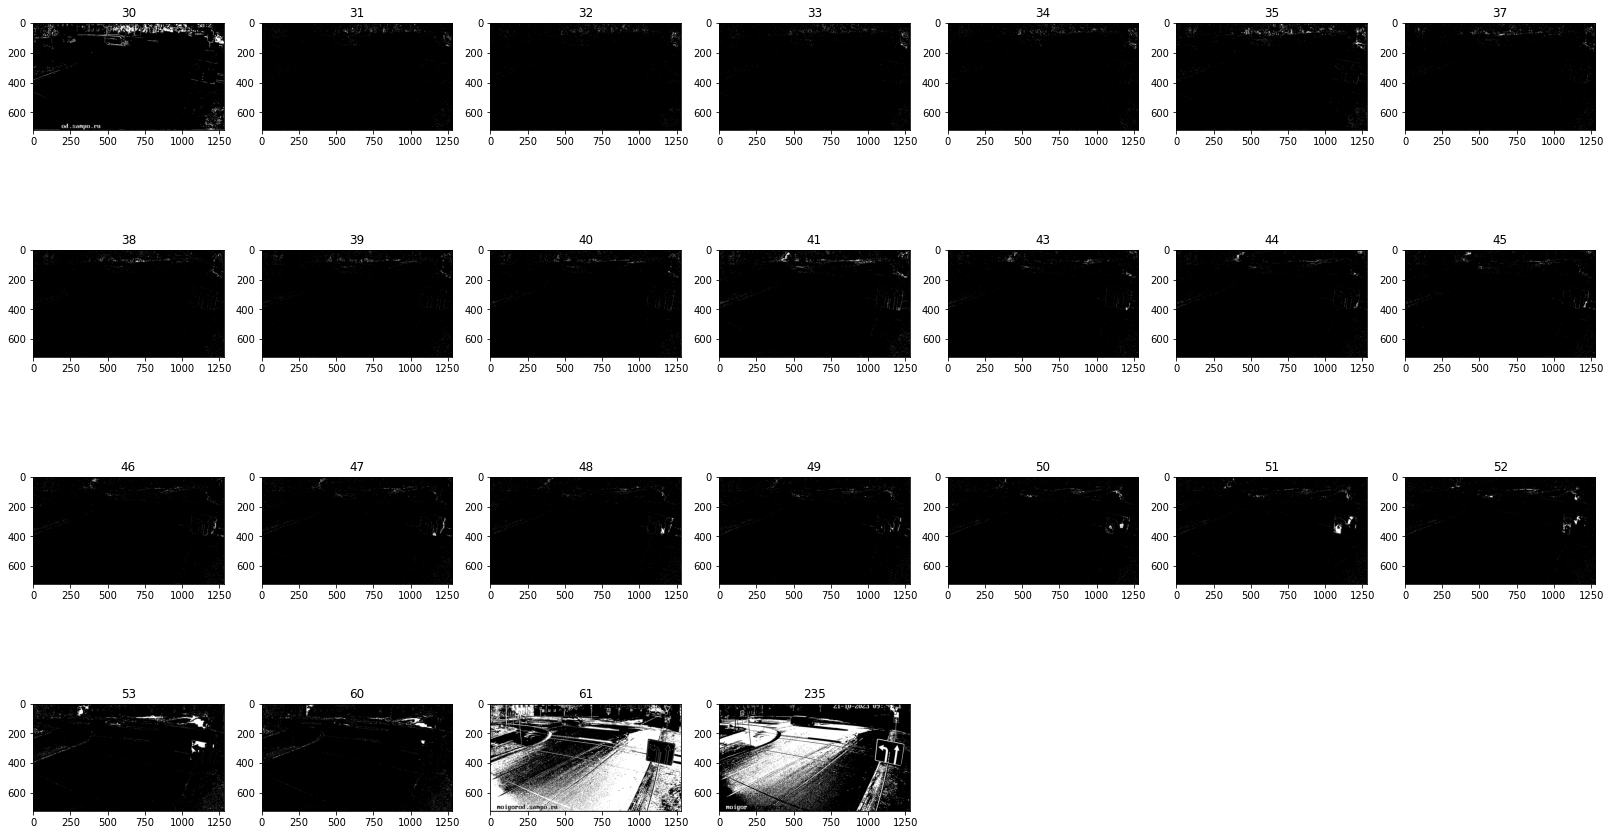

In [13]:
# посмотрим на маски
showOneLine([mask*255 for mask in masks],[str(x) for x in levels],dim = 7)

Найдем ортогональную проекцию f на линейное подпространство комбинаций индикаторных функций.

In [14]:
def approximation(img, masks):
    result = img.copy()*0
    colors = []
    for mask in masks:
        color = np.mean(np.ma.array(img,mask=1-mask))
        colors.append(int(color))
        result = result + mask*color
    return result.astype(np.uint8), colors


[22, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 58, 118, 172]


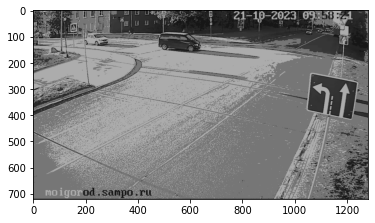

In [15]:
example_f_proj, c = approximation(f_gray, masks)
print(c)
plt.imshow(cv2.cvtColor(example_f_proj, cv2.COLOR_BGR2RGB))

Посчитаем невязку

In [16]:
def nevayz(image, proj):
    return np.square(np.linalg.norm(image - proj))

In [17]:
nevayz(f_gray,example_f_proj)

23392846891.0

Выполним релаксационный алгоритм:

In [18]:
def relaxation(src, show=False, N=20):
    global levels
    
    levels = get_levels(src, threshold=16)

    image = src.copy()
    
    images, masks, errors = [], [] ,[]

    for i in range(N):
        #Определяем индикаторные функции для новых цветов
        masks = get_masks(src, levels)
        

        #Вычисляем проекцию и новые цвета
        image, levels = approximation(src, masks)
        
        images.append(image)
        errors.append(nevayz(src,image))
        
        print('.',end='')# showOneLine(images,[str(x) for x in range(len(images))],dim = 5)
        
    if show:
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(errors)),errors)
        plt.show()

    return images, masks, levels

....................

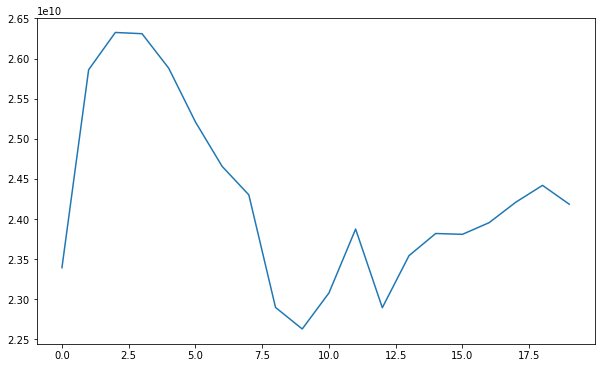

In [19]:
# тут он скорее всего не будет невозростающим, хз почему, мне на сдаче ничего по этому поводу не сказали
images, masks, levels = relaxation(f_gray,True,N=20)

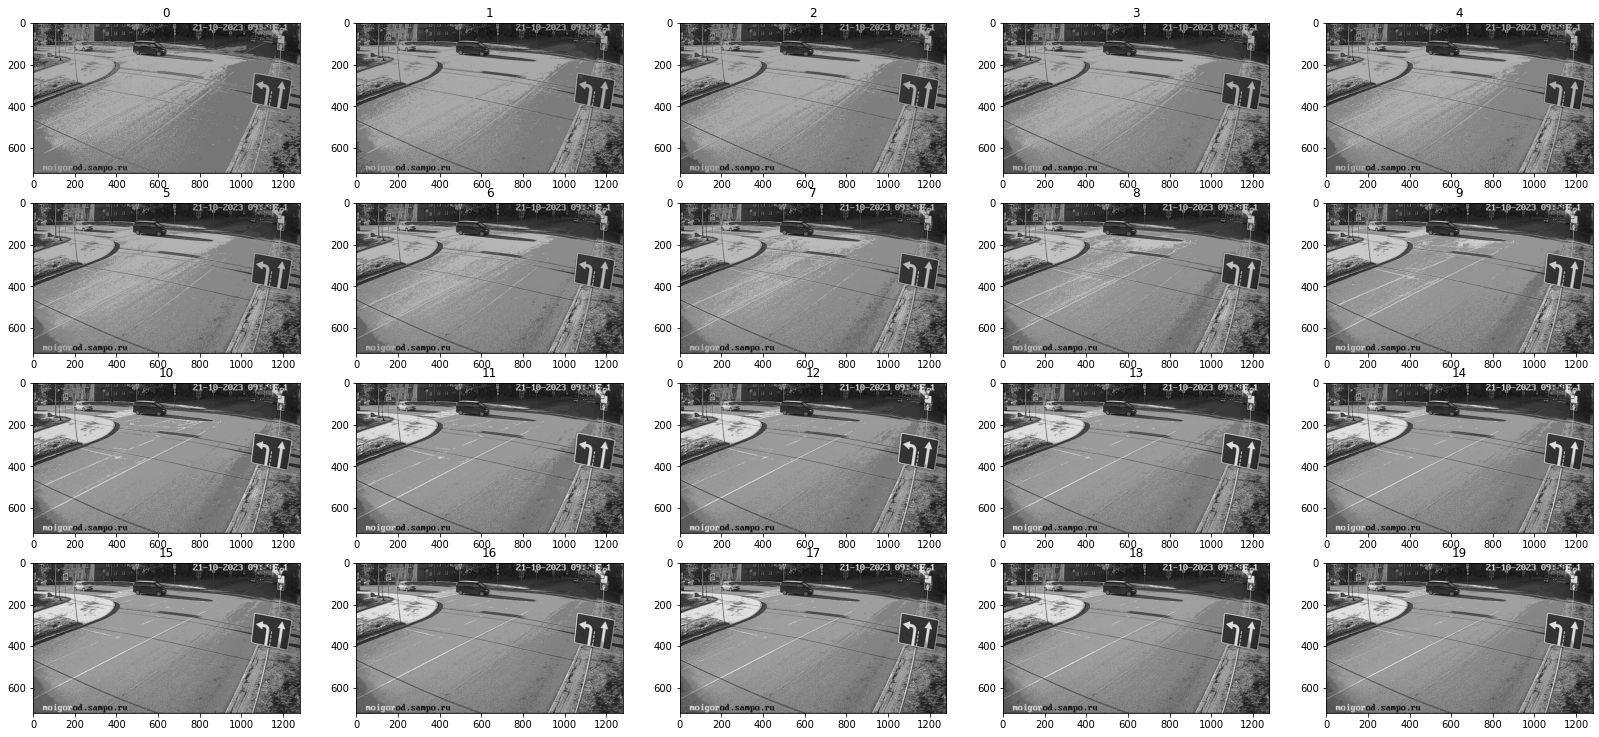

In [20]:
# посмотрим на вид аппроксимации в зависимости от итерации
showOneLine(images,[str(x) for x in range(len(images))],dim = 5)

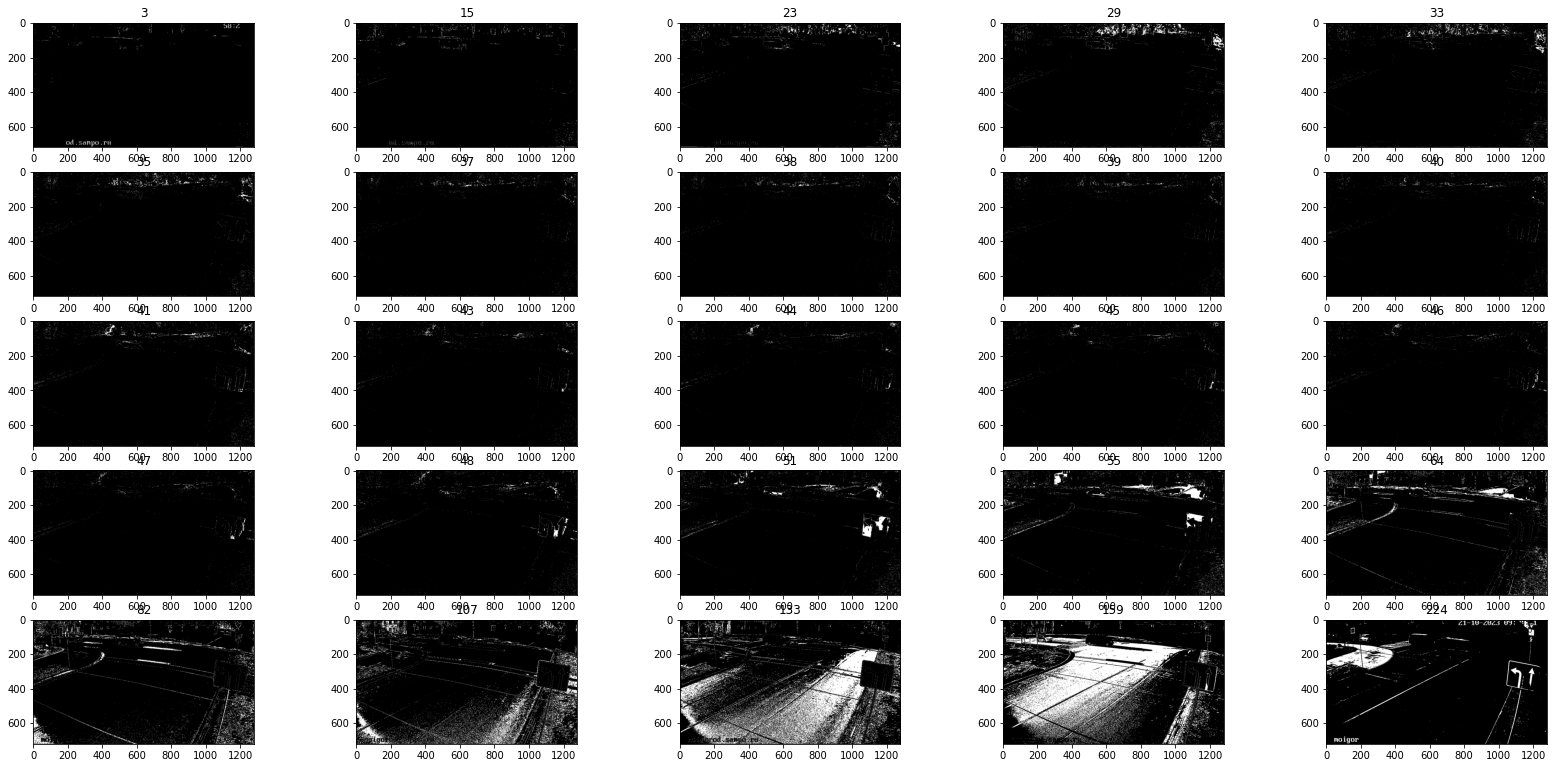

In [21]:
# посмотрим на маски
showOneLine([mask*255 for mask in masks],[str(level) for level in levels],dim = 5)


### 3. Для каждой полученной формы фрагмента изображения f и соответствующего фрагмента изображения g
вычисляется их морфологическая разность, которая рассматривается как соответствующий фрагмент формируемого изображения h как отличия изображений.

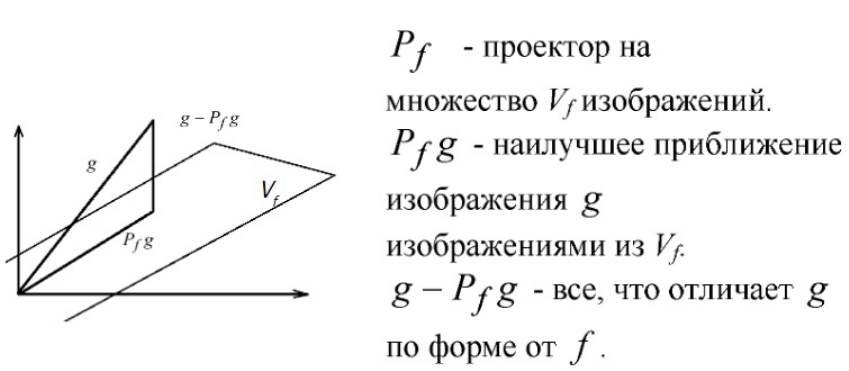

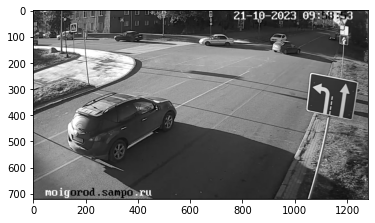

In [22]:
# Загружаем изображение
g = cv2.imread('g.png')
g_gray = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(g_gray, cv2.COLOR_BGR2RGB))

In [23]:
def projection(g,f,masks, levels):
    p = g.copy()*0
    colors = []
    for mask in masks:
        colors.append(np.ma.array(g,mask=1-mask).mean())
    for color, level in zip(colors,levels):
        p[(f==level)] = color
        
    return p

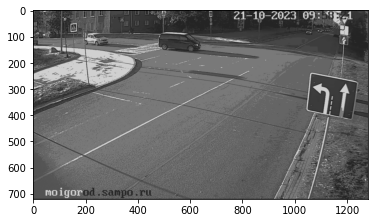

In [24]:
g_proj = projection(g_gray,images[-1],masks,levels)
plt.imshow(cv2.cvtColor(g_proj, cv2.COLOR_BGR2RGB))

In [25]:
def mrp_diff(form,g,masks,levels):
    g_proj = projection(g,form,masks,levels)
    return cv2.absdiff(g,g_proj)

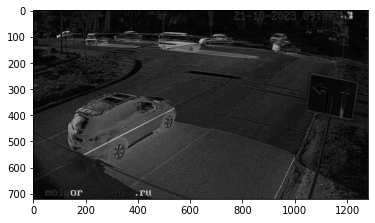

In [26]:
example_diff = mrp_diff(images[-1],g_gray,masks,levels)
plt.imshow(cv2.cvtColor(example_diff, cv2.COLOR_BGR2RGB))

### 4. Изображения f и g разделяются на фрагменты (по возможности, непересекающиеся) заданного размера.
Разделим изображение

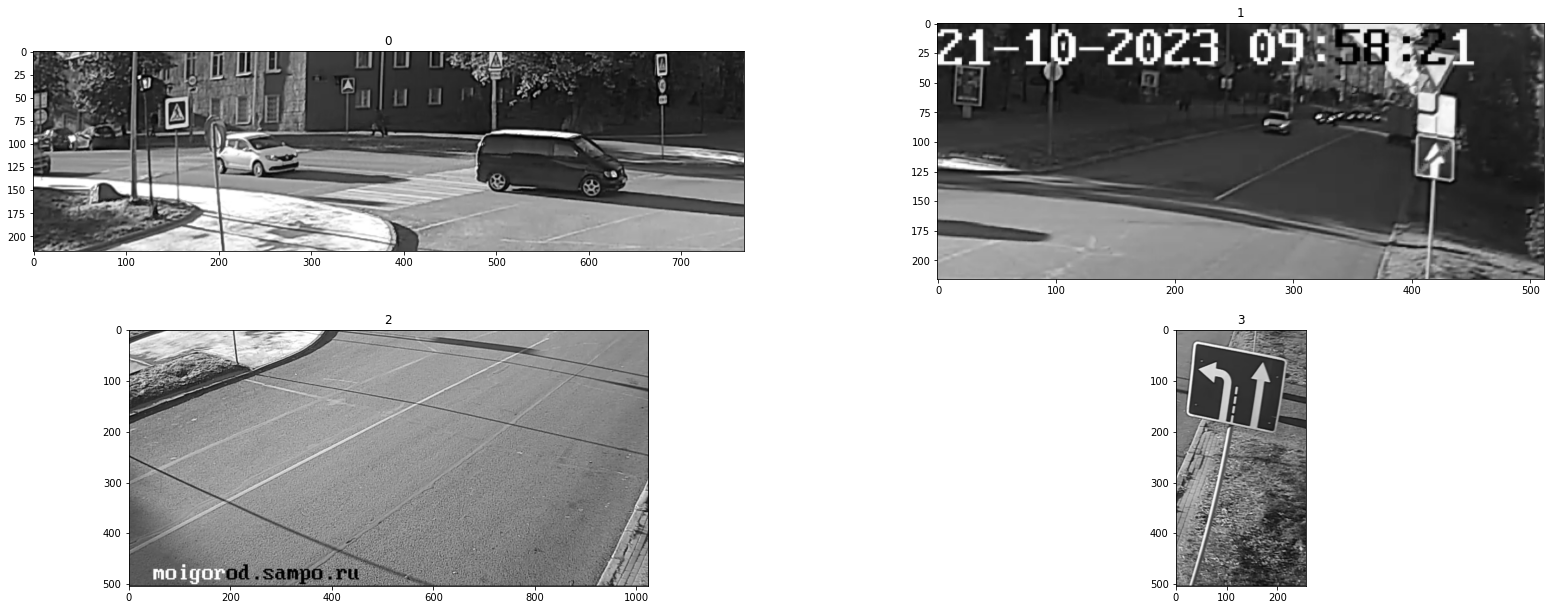

In [27]:
height, width = f_gray.shape

    # Разрежьте изображение на две части по горизонтали (пополам)
middle_y = int(height*0.3)   # Середина высоты
middle_x =  int(width*0.6)  # Середина ширины
top_half = f_gray[:middle_y, :]  # Верхняя половина
bottom_half = f_gray[middle_y:, :]  # Нижняя половина


left_top = top_half[:, :middle_x]  # Левая половина
right_top = top_half[:, middle_x:]  # Правая половина
left_bottom = bottom_half[:, :int(width*0.8)]
right_bottom = bottom_half[:, int(width*0.8):]

showOneLine([left_top, right_top,left_bottom,right_bottom],[str(x) for x in range(4)],dim = 2)


In [28]:
top_half_g = g_gray[:middle_y, :]  # Верхняя половина
bottom_half_g = g_gray[middle_y:, :]  # Нижняя половина

left_top_g = top_half_g[:, :middle_x]  # Левая половина
right_top_g = top_half_g[:, middle_x:]  # Правая половина
left_bottom_g = bottom_half_g[:, :int(width*0.8)]
right_bottom_g = bottom_half_g[:, int(width*0.8):]

In [29]:
def get_diff_img(f,g):
    images, masks, levels = relaxation(f)
    return mrp_diff(images[-1],g,masks,levels)

In [30]:
tmp_img = []
for f,g in zip([left_top, right_top,left_bottom,right_bottom],[left_top_g,right_top_g, left_bottom_g,right_bottom_g]):
    tmp_img.append(get_diff_img(f,g))



................................................................................

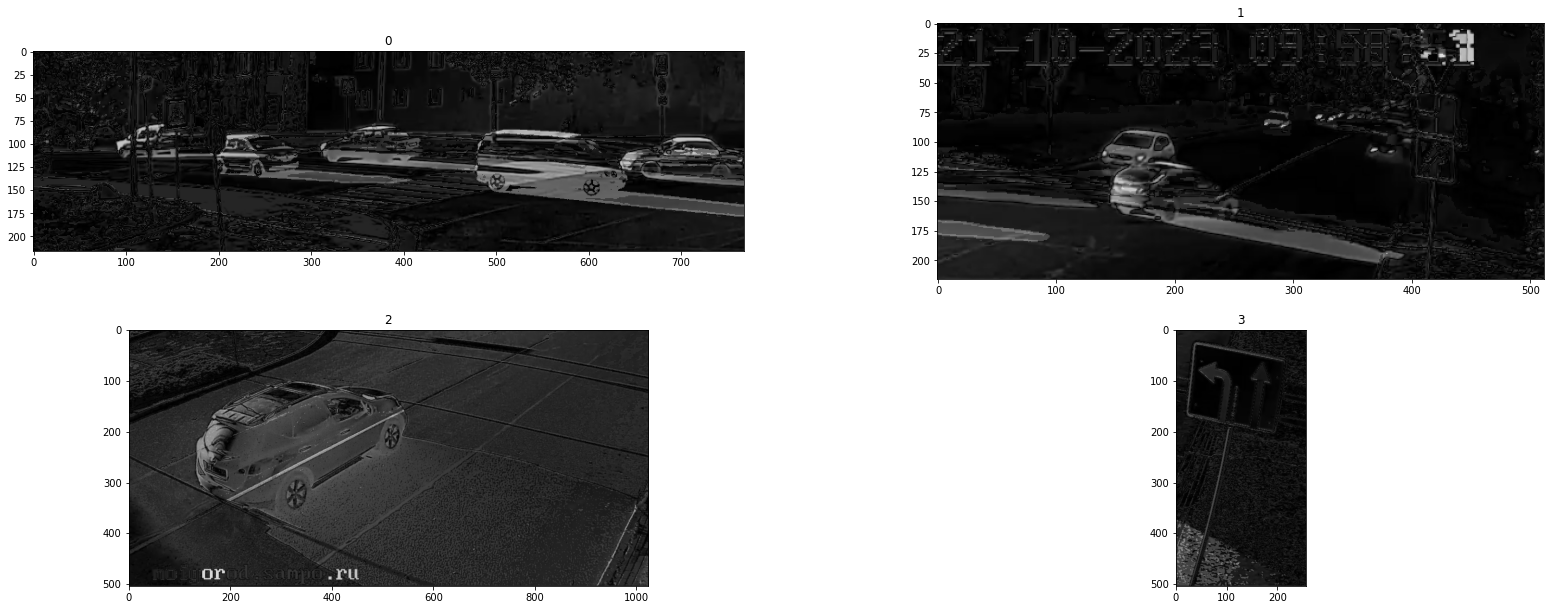

True

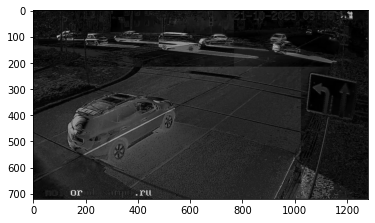

In [31]:
showOneLine(tmp_img,[str(x) for x in range(4)],dim = 2)

merged_image = np.hstack((tmp_img[0], tmp_img[1]))
merged_image2 = np.hstack((tmp_img[2], tmp_img[3]))
merged_image = np.vstack((merged_image,merged_image2))

plt.imshow(cv2.cvtColor(merged_image, cv2.COLOR_BGR2RGB))
cv2.imwrite('diff.png', merged_image)

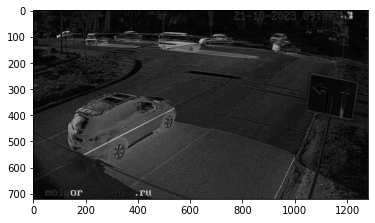

In [32]:
# Отобразим результаты для варианта без разделения на части
plt.imshow(cv2.cvtColor(example_diff, cv2.COLOR_BGR2RGB))


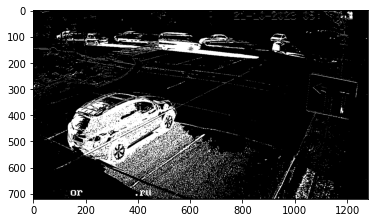

In [33]:
threshold_value = 64  # Adjust this threshold value as needed
_, binary_image = cv2.threshold(example_diff, threshold_value, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))